<a href="https://colab.research.google.com/github/AashiDutt/AI-and-ML-for-Coders/blob/main/Cats_vs_Dogs_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

In [2]:
data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
data_file_name = "catsdogs.zip"
download_dir = '/tmp/'
urllib.request.urlretrieve(data_url, data_file_name)
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [4]:
# Data in raw form - not separated into training and testing
# os.mkdir -creates directory at the path given 

try:
  os.mkdir('/tmp/cats-v-dogs')
  os.mkdir('/tmp/cats-v-dogs/training')
  os.mkdir('/tmp/cats-v-dogs/testing')
  os.mkdir('/tmp/cats-v-dogs/training/cats')
  os.mkdir('/tmp/cats-v-dogs/training/dogs')
  os.mkdir('/tmp/cats-v-dogs/testing/cats')
  os.mkdir('/tmp/cats-v-dogs/testing/dogs')

except OSError:
  pass



In [5]:
# Split data into train and test sets

import random
from shutil import copyfile
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)
  
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = 0.9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR,split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)


666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [6]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs')))

11250
11250
1250
1250


In [7]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                  )

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size = 100,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                    batch_size = 100,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

Found 22498 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


In [8]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

pre_trained_model = InceptionV3(input_shape = (150,150,3), include_top = False, weights = None)

pre_trained_model.load_weights(weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 7, 7, 768)


In [9]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer= RMSprop(lr = 0.0001), 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history = model.fit(train_generator, 
                    validation_data = validation_generator,
                    epochs = 20,
                    verbose = 1
                    )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
225/225 [==============================] - 223s 931ms/step - loss: 0.2242 - accuracy: 0.9123 - val_loss: 0.0919 - val_accuracy: 0.9620
Epoch 2/20
225/225 [==============================] - 205s 913ms/step - loss: 0.1551 - accuracy: 0.9364 - val_loss: 0.0831 - val_accuracy: 0.9676
Epoch 3/20
225/225 [==============================] - 204s 908ms/step - loss: 0.1378 - accuracy: 0.9441 - val_loss: 0.0852 - val_accuracy: 0.9664
Epoch 4/20
225/225 [==============================] - 204s 905ms/step - loss: 0.1307 - accuracy: 0.9473 - val_loss: 0.0994 - val_accuracy: 0.9640
Epoch 5/20
225/225 [==============================] - 204s 905ms/step - loss: 0.1263 - accuracy: 0.9518 - val_loss: 0.0693 - val_accuracy: 0.9760
Epoch 6/20
225/225 [==============================] - 203s 903ms/step - loss: 0.1269 - accuracy: 0.9512 - val_loss: 0.0609 - val_accuracy: 0.9784
Epoch 7/20
225/225 [==============================] - 204s 907ms/step - loss: 0.1260 - accuracy: 0.9524 - val_loss: 0.0671 -

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<Figure size 432x288 with 0 Axes>

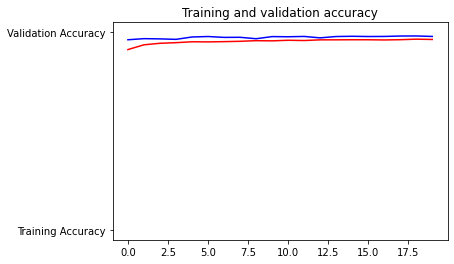

<Figure size 432x288 with 0 Axes>

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()


In [14]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' +fn
  img = image.load_img(path, target_size= (150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  if classes[0] >0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving cat-551554__340.jpg to cat-551554__340.jpg
Saving dog.jfif to dog.jfif
Saving dog1.jfif to dog1.jfif
[[0.]]
cat-551554__340.jpg is a cat
[[0.]]
dog.jfif is a cat
[[0.]]
dog1.jfif is a cat
